In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [23]:
data = pd.read_pickle("/Users/weilu/Research/data/openAWSEM_benchmark.pkl")
data["time_in_hour"] = data["time"] / 3600


from sklearn.linear_model import LinearRegression
data_lammps = data.query("Scheme == 'LAMMPS'")
y = data_lammps.time_in_hour.values
X = data_lammps.Length.values
coefs = np.polynomial.polynomial.polyfit(X, y, 2)
ffit = np.polynomial.polynomial.Polynomial(coefs)

data_openMM = data.query("Scheme == 'openMM'")
y_openMM = data_openMM.time_in_hour.values
X_openMM = data_openMM.Length.values
coefs_openMM = np.polynomial.polynomial.polyfit(X_openMM, y_openMM, 2)
ffit_openMM = np.polynomial.polynomial.Polynomial(coefs_openMM)

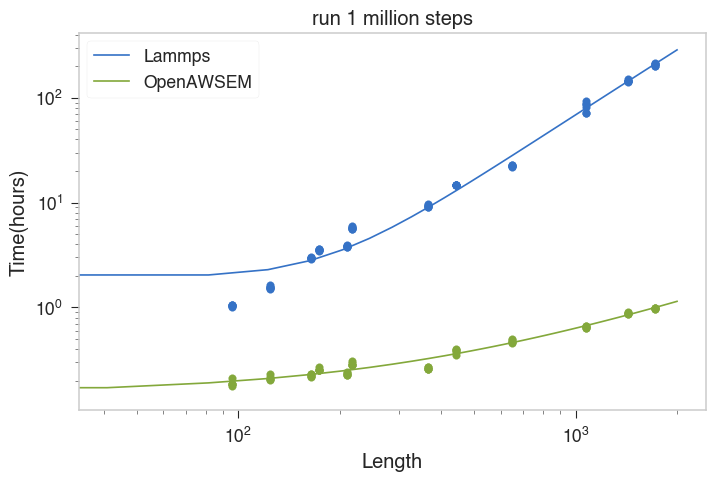

In [28]:
x = np.linspace(0, 2000)
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.plot(x, ffit_openMM(x))
plt.scatter(X_openMM, y_openMM)
# plt.plot(x, 10*x)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Length")
plt.ylabel("Time(hours)")
plt.legend(["Lammps", "OpenAWSEM"])
plt.title("run 1 million steps")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/benchmark_logscale.png", dpi=300)

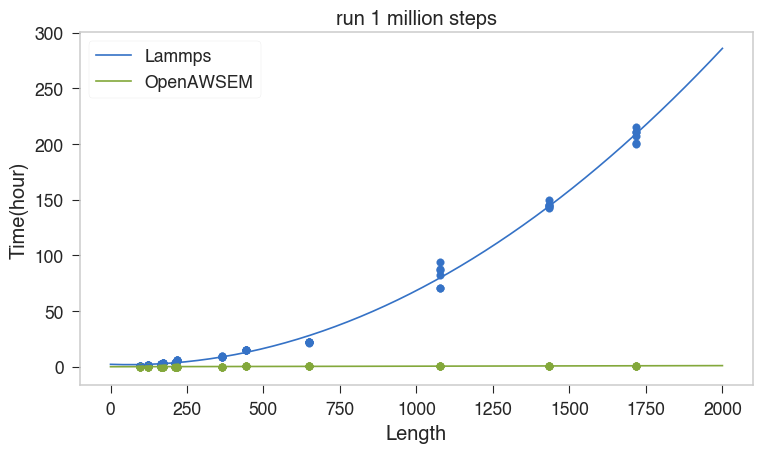

In [27]:
x = np.linspace(0, 2000)
plt.scatter(X, y)
plt.plot(x, ffit(x))
plt.plot(x, ffit_openMM(x))
plt.scatter(X_openMM, y_openMM)
# plt.plot(x, 10*x)

plt.xlabel("Length")
plt.ylabel("Time(hour)")
plt.legend(["Lammps", "OpenAWSEM"])
plt.title("run 1 million steps")
plt.tight_layout()
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/benchmark.png", dpi=300)

In [73]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/complete_run_without_er_gamma_yesCysCys_12-02.csv", index_col=0)
a = pd.read_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv", index_col=0)
data = data.merge(a, on="Protein")


/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Text(0.5, 1.0, 'structure prediction results of 5 Disufide rich proteins')

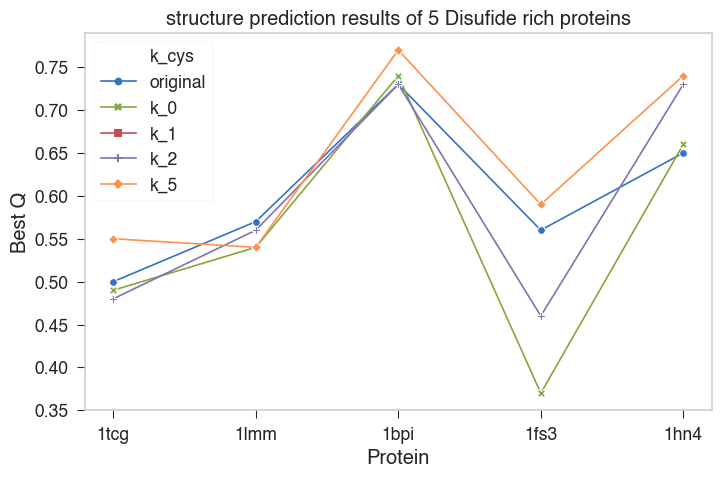

In [74]:
memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20' and k_cys != 'k_1'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["k_cys", "Protein"]).tail(1).sort_values(['k_cys', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys,  ["original", "k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"structure prediction results of 5 Disufide rich proteins")
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_complete.png", dpi=300)

In [91]:

Q_max = filtered_data.sort_values('Q').groupby(["k_cys", "Protein", "Run"]).tail(1).sort_values(['k_cys', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys,  ["k_0", "k_2", "k_5", "original"])

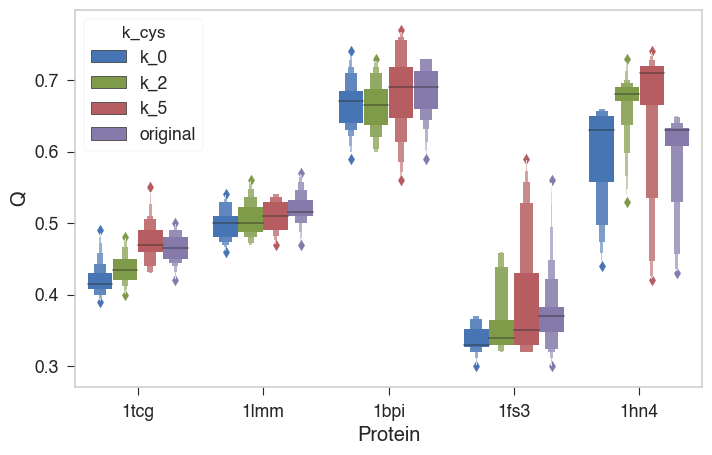

In [97]:
sns.boxenplot("Protein", "Q", data=Q_max, hue="k_cys")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_bestQ_from_each_run.png", dpi=300)

In [95]:
Q_last = filtered_data.groupby(["k_cys", "Protein", "Run"]).tail(10).sort_values(['k_cys', "Q"])
Q_last.Protein = pd.Categorical(Q_last.Protein, a.sort_values("Length").Protein.values)
Q_last.k_cys = pd.Categorical(Q_last.k_cys,  ["k_0", "k_2", "k_5", "original"])

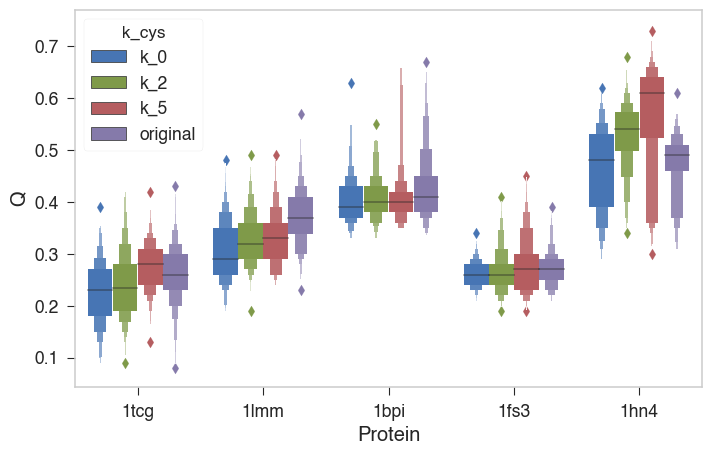

In [98]:
sns.boxenplot("Protein", "Q", data=Q_last, hue="k_cys")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_last10frame_from_each_run.png", dpi=300)

1tcg,6, μ/α Conotoxin-like,Small disulfide-closed loop
1lmm,6
1bpi,6
1fs3,8
1hn4,12,Phospholipase A2

# new old beta

In [99]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/new_old_beta_11-23.csv", index_col=0)

In [100]:
filtered_data = data.query("subfolder != 'no_beta_pap'")
Q_max = filtered_data.sort_values('Q').groupby(["subfolder", "Protein"]).tail(1)

In [109]:
filtered_data = filtered_data.query("Steps > 2491").reset_index(drop=True)

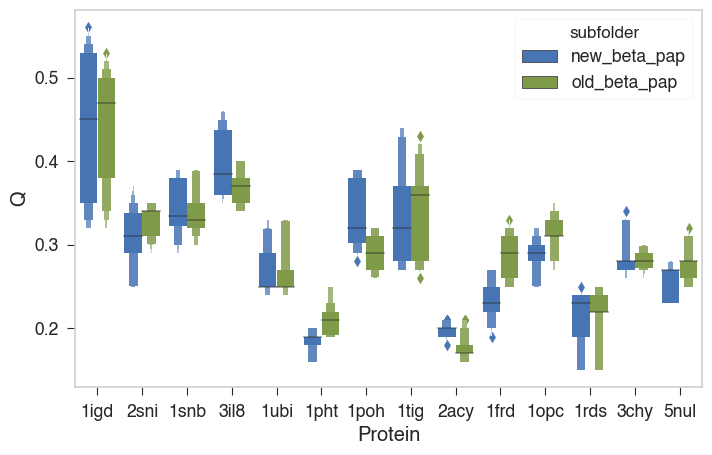

In [111]:
sns.boxenplot("Protein", "Q", data=filtered_data, hue="subfolder")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/new_old_beta_comparison_last_10frames_from_each_run", dpi=300)

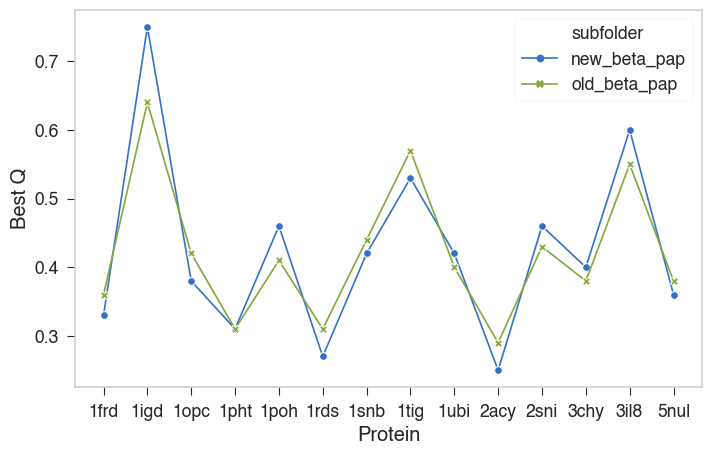

In [62]:
# sns.boxenplot("Protein", "Q", data=Q_max, hue="subfolder")
sns.lineplot("Protein", "Q", hue="subfolder", markers=True, data=Q_max, style="subfolder", dashes=False)
plt.ylabel("Best Q")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/new_old_beta_comparison", dpi=300)

In [3]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/second_hybrid_protein_simulation_third_3_12-16.csv", index_col=0)

# length_info = pd.read_csv("/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/length_info.csv", index_col=0)
length_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv", index_col=0)

length_info = length_info.sort_values("Length").reset_index()
pdb_list_sorted_by_length = list(length_info.Protein.unique())
length_info_sorted_by_length = list(length_info.Length.unique())
label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    label_list.append(p+f"\n{n}")
# pd.set_option('max_colwidth', 100)

# create label
sub_label_list = []
pdb_list_sorted_by_length = ['2jo1', '4p79', '4a2n', '1py6', '3kp9', '4nv6', '5xpd', '2xov', '5d91', '1u19', '6g7o', '6a93', '5dsg', '1pv6', '6e67A']
length_info_sorted_by_length = length_info["Length"].tolist()
sub_label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    sub_label_list.append(p+f"\n{n}")

sub_pdb_list = length_info["Protein"].tolist()
data.Protein = pd.Categorical(data.Protein, 
                      categories=sub_pdb_list)
convert_dic = {"third_3":"hybrid contact", "third":"HE",
              "third_1":"contact as in water", "fifth":"no contact", "third_2":"contact as in membrane"}


In [8]:
plt.rcParams['figure.figsize'] = 0.8*np.array([16.18033, 10])    #golden ratio

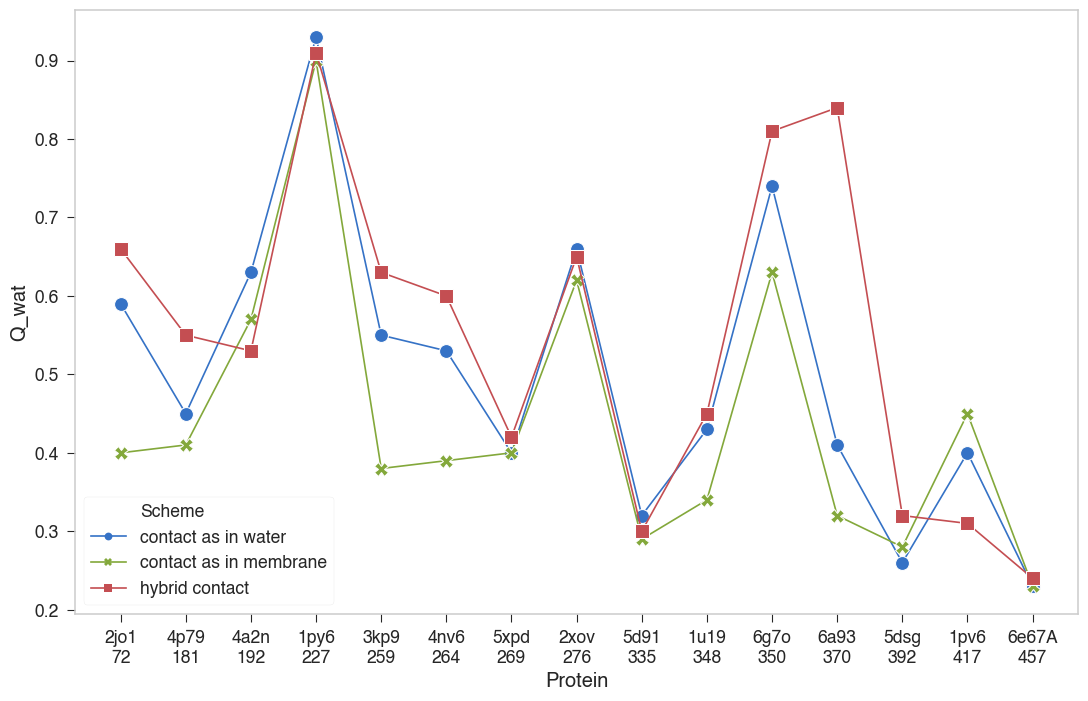

In [10]:
y = "Q_wat"
d = data.query("Steps > 1500").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])
sub_data = max_Q_mem_data.query("Scheme in ['hybrid contact', 'contact as in water', 'contact as in membrane']")
# sub_data = max_Q_mem_data
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Scheme", hue="Scheme", data=sub_data, dashes=False)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/Q_wat_new.png", dpi=300)

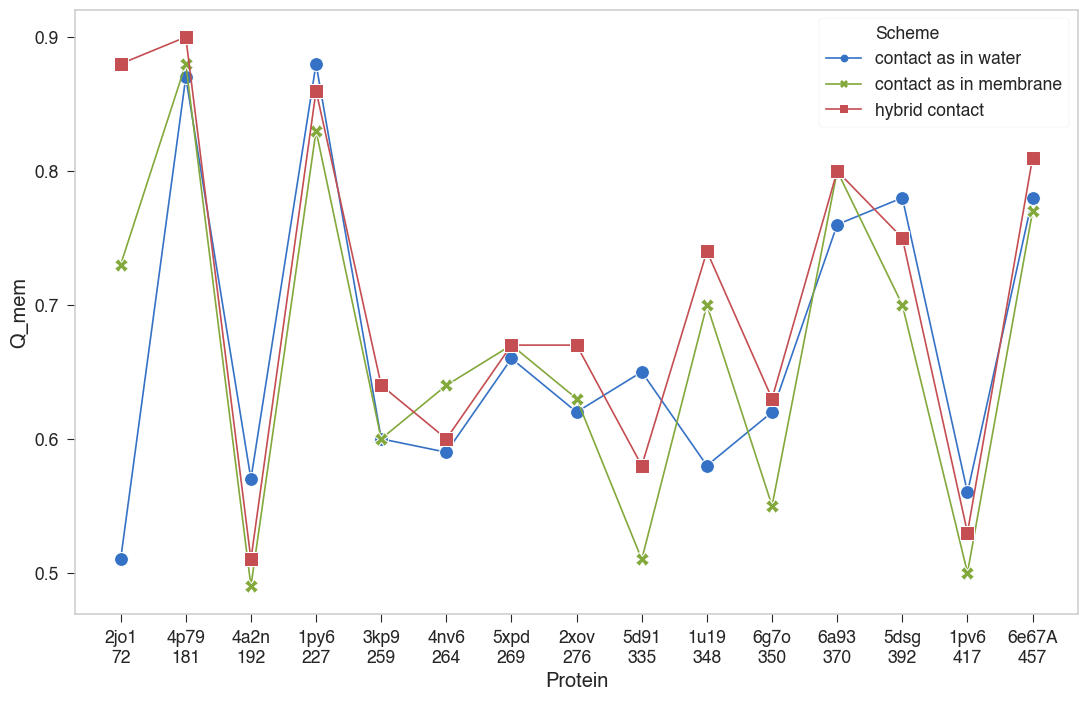

In [11]:
y = "Q_mem"
d = data.query("Steps > 1500").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])
sub_data = max_Q_mem_data.query("Scheme in ['hybrid contact', 'contact as in water', 'contact as in membrane']")
# sub_data = max_Q_mem_data
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Scheme", hue="Scheme", data=sub_data, dashes=False)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/Q_mem_new.png", dpi=300)

In [65]:
x = np.linspace(0, 20, 100)

In [66]:
x

array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
        1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
        2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283,
        3.03030303,  3.23232323,  3.43434343,  3.63636364,  3.83838384,
        4.04040404,  4.24242424,  4.44444444,  4.64646465,  4.84848485,
        5.05050505,  5.25252525,  5.45454545,  5.65656566,  5.85858586,
        6.06060606,  6.26262626,  6.46464646,  6.66666667,  6.86868687,
        7.07070707,  7.27272727,  7.47474747,  7.67676768,  7.87878788,
        8.08080808,  8.28282828,  8.48484848,  8.68686869,  8.88888889,
        9.09090909,  9.29292929,  9.49494949,  9.6969697 ,  9.8989899 ,
       10.1010101 , 10.3030303 , 10.50505051, 10.70707071, 10.90909091,
       11.11111111, 11.31313131, 11.51515152, 11.71717172, 11.91919192,
       12.12121212, 12.32323232, 12.52525253, 12.72727273, 12.92929293,
       13.13131313, 13.33333333, 13.53535354, 13.73737374, 13.93

In [71]:
y = np.exp(-4*(x))

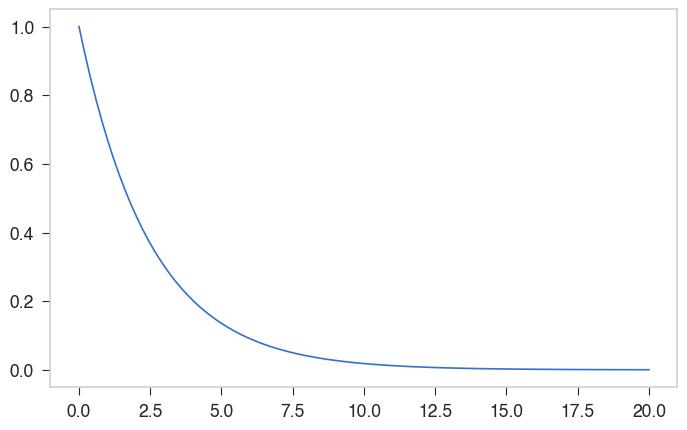

In [72]:
plt.plot(x, y)

In [70]:
y

array([1.00000000e+00, 4.45712654e-01, 1.98659770e-01, 8.85451733e-02,
       3.94657042e-02, 1.75903638e-02, 7.84024772e-03, 3.49449762e-03,
       1.55754181e-03, 6.94216093e-04, 3.09420897e-04, 1.37912809e-04,
       6.14694843e-05, 2.73977270e-05, 1.22115136e-05, 5.44282614e-06,
       2.42593648e-06, 1.08127059e-06, 4.81935984e-07, 2.14804966e-07,
       9.57412917e-08, 4.26731052e-08, 1.90199430e-08, 8.47742926e-09,
       3.77849750e-09, 1.68412415e-09, 7.50635444e-10, 3.34567716e-10,
       1.49121065e-10, 6.64651454e-11, 2.96243564e-11, 1.32039505e-11,
       5.88516782e-12, 2.62309377e-12, 1.16914609e-12, 5.21103205e-13,
       2.32262292e-13, 1.03522243e-13, 4.61411736e-14, 2.05657049e-14,
       9.16639493e-15, 4.08557821e-15, 1.82099391e-15, 8.11640028e-16,
       3.61758231e-16, 1.61240221e-16, 7.18668069e-17, 3.20319453e-17,
       1.42770433e-17, 6.36345888e-18, 2.83627414e-18, 1.26416328e-18,
       5.63453569e-19, 2.51138386e-19, 1.11935556e-19, 4.98910939e-20,
      

In [11]:
def convert_simulation_to_iteration_gamma(fromFile, toFile):
    a = np.loadtxt(fromFile)
    a = -a

    with open(toFile, "w") as out:
        for i in range(210):
            g = a[i][0]
            out.write(f"{g}\n")
        for i in range(210):
            g = a[i+210][0]
            out.write(f"{g}\n")
        for i in range(210):
            g = a[i+210][1]
            out.write(f"{g}\n")

In [12]:
pre = "/Users/weilu/Research/server/apr_2020/openAWSEM_archived_data/convert_simulation_to_iteration_gamma/"
fromFile = f"{pre}/gamma.dat"
toFile = f"{pre}/iteration_gamma.dat"
import numpy as np
convert_simulation_to_iteration_gamma(fromFile, toFile)

In [13]:
pre = "/Users/weilu/Research/server/apr_2020/openAWSEM_archived_data/convert_simulation_to_iteration_gamma/"
fromFile = f"{pre}/membrane_gamma.dat"
toFile = f"{pre}/iteration_membrane_gamma.dat"
import numpy as np
convert_simulation_to_iteration_gamma(fromFile, toFile)

In [8]:
pre = "/Users/weilu/Research/server/apr_2020/openAWSEM_archived_data/convert_simulation_to_iteration_gamma/"
fromFile = f"{pre}/gamma.dat"
toFile = f"{pre}/iteration_gamma.dat"
import numpy as np
a = np.loadtxt(fromFile)
a = -a

with open(toFile, "w") as out:
    for i in range(210):
        g = a[i][0]
        out.write(f"{g}\n")
    for i in range(210):
        g = a[i+210][0]
        out.write(f"{g}\n")
    for i in range(210):
        g = a[i+210][1]
        out.write(f"{g}\n")